## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/train_with_econ_wout_zeros.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4675 entries, 0 to 4674
Data columns (total 30 columns):
EVENT_ID              4675 non-null int64
INJURIES_DIRECT       4675 non-null int64
DEATHS_DIRECT         4675 non-null int64
DAMAGE_PROPERTY       4675 non-null float64
DAMAGE_CROPS          4675 non-null float64
DURATION_SECONDS      4675 non-null float64
BEGIN_LAT             4675 non-null float64
BEGIN_LON             4675 non-null float64
TOR_LENGTH            4675 non-null float64
TOR_WIDTH             4675 non-null float64
BEGIN_DATE_TIME       4675 non-null float64
YEAR                  4675 non-null int64
CZ_NAME               4675 non-null object
STATE                 4675 non-null object
OPEN_WATER_PROP       4675 non-null float64
DEV_OPEN_PROP         4675 non-null float64
DEV_LOW_PROP          4675 non-null float64
DEV_MED_PROP          4675 non-null float64
DEV_HIGH_PROP         4675 non-null float64
DECID_FOREST_PROP     4675 non-null float64
EVERGR_FOREST_PROP    4

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [3]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4675 entries, 0 to 4674
Data columns (total 1 columns):
DAMAGE_PROPERTY    4675 non-null float64
dtypes: float64(1)
memory usage: 36.6 KB


In [4]:
# The independent variables
tornado_features = tor_df.iloc[:, 5:]


# Get rid of year and county name
tornado_features = tornado_features.drop(["YEAR",
                                          "CZ_NAME",
                                          "STATE"],
                                         axis = 1)



# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4675 entries, 0 to 4674
Data columns (total 22 columns):
DURATION_SECONDS      4675 non-null float64
BEGIN_LAT             4675 non-null float64
BEGIN_LON             4675 non-null float64
TOR_LENGTH            4675 non-null float64
TOR_WIDTH             4675 non-null float64
BEGIN_DATE_TIME       4675 non-null float64
OPEN_WATER_PROP       4675 non-null float64
DEV_OPEN_PROP         4675 non-null float64
DEV_LOW_PROP          4675 non-null float64
DEV_MED_PROP          4675 non-null float64
DEV_HIGH_PROP         4675 non-null float64
DECID_FOREST_PROP     4675 non-null float64
EVERGR_FOREST_PROP    4675 non-null float64
MIXED_FOREST_PROP     4675 non-null float64
SHRUB_SCRUB_PROP      4675 non-null float64
GRASS_LAND_PROP       4675 non-null float64
PASTURE_HAY_PROP      4675 non-null float64
CULT_CROPS_PROP       4675 non-null float64
WOOD_WETLAND_PROP     4675 non-null float64
HERB_WETLAND_PROP     4675 non-null float64
BARREN_LAND_P

In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.5951
 1.2772
 0.6926
   ⋮    
 0.7159
 0.8757
 0.4558
[torch.DoubleTensor of size 4675x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


 1.9605e-01  3.8572e-01 -7.9828e-01  ...  -2.1285e-01 -6.9525e-01  1.2000e+00
-1.4814e-02  1.8039e-01  9.5833e-01  ...  -9.0635e-01  2.2024e+00 -5.1531e-01
 5.5754e-01 -1.0135e+00  7.6543e-01  ...   1.6766e+00 -6.9525e-01  4.9763e-01
                ...                   ⋱                   ...                
 9.6160e-01  6.1517e-02  4.1479e-01  ...  -9.0635e-01 -6.9525e-01 -8.3143e-02
 8.2443e-01  3.3896e-02  5.4983e-01  ...   3.6783e-01  1.1558e+00 -1.2968e+00
-3.7344e-01 -7.4953e-01  9.0271e-01  ...  -9.0635e-01  6.8160e-01 -1.6639e+00
[torch.DoubleTensor of size 4675x22]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


 1.9605e-01  3.8572e-01 -7.9828e-01  ...  -2.1285e-01 -6.9525e-01  1.2000e+00
-1.4814e-02  1.8039e-01  9.5833e-01  ...  -9.0635e-01  2.2024e+00 -5.1531e-01
 5.5754e-01 -1.0135e+00  7.6543e-01  ...   1.6766e+00 -6.9525e-01  4.9763e-01
                ...                   ⋱                   ...                
 9.6160e-01  6.1517e-02  4.1479e-01  ...  -9.0635e-01 -6.9525e-01 -8.3143e-02
 8.2443e-01  3.3896e-02  5.4983e-01  ...   3.6783e-01  1.1558e+00 -1.2968e+00
-3.7344e-01 -7.4953e-01  9.0271e-01  ...  -9.0635e-01  6.8160e-01 -1.6639e+00
[torch.FloatTensor of size 4675x22]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                            torch.nn.ReLU(),
                            torch.nn.Linear(15, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 4e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

In [12]:
# Get the iterations
iterations = list(range(0, 10000))

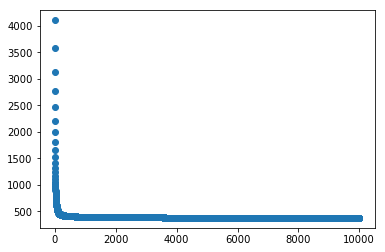

In [13]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4675)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(4675)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()

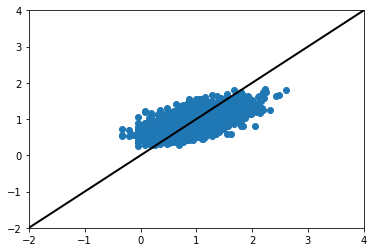

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/cv_with_econ_wout_zeros.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [3]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)

In [18]:
# Validation set predictors
valid_predictors = valid_df.iloc[:, 5:]

valid_predictors = valid_predictors.drop(["YEAR",
                                          "CZ_NAME",
                                          "STATE"],
                                         axis = 1)


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)

In [19]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(15, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight

In [20]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 286.9640
[torch.FloatTensor of size 1]

In [21]:
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 22 columns):
DURATION_SECONDS      1604 non-null float64
BEGIN_LAT             1604 non-null float64
BEGIN_LON             1604 non-null float64
TOR_LENGTH            1604 non-null float64
TOR_WIDTH             1604 non-null float64
BEGIN_DATE_TIME       1604 non-null float64
OPEN_WATER_PROP       1604 non-null float64
DEV_OPEN_PROP         1604 non-null float64
DEV_LOW_PROP          1604 non-null float64
DEV_MED_PROP          1604 non-null float64
DEV_HIGH_PROP         1604 non-null float64
DECID_FOREST_PROP     1604 non-null float64
EVERGR_FOREST_PROP    1604 non-null float64
MIXED_FOREST_PROP     1604 non-null float64
SHRUB_SCRUB_PROP      1604 non-null float64
GRASS_LAND_PROP       1604 non-null float64
PASTURE_HAY_PROP      1604 non-null float64
CULT_CROPS_PROP       1604 non-null float64
WOOD_WETLAND_PROP     1604 non-null float64
HERB_WETLAND_PROP     1604 non-null float64
BARREN_LAND_P

In [22]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1604)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [23]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(1604)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

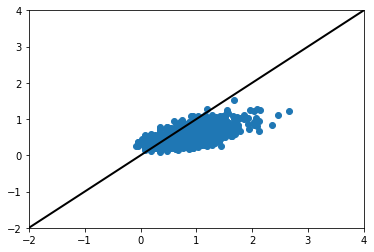

In [24]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.2: Test Set Performance

In [25]:
# Import data
test_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/test_with_econ_wout_zeros.csv")


# Validation set outcomes
test_outcomes = test_df.iloc[:, [3]]


# Make the validation outcomes into a numpy array
test_outcomes_array = test_outcomes.values


# Makes the numpy array into a torch Tensor
test_outcomes_Tensor = torch.from_numpy(test_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
test_outcomes_Tensor = test_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
test_outcomes_Variable = Variable(test_outcomes_Tensor)

In [26]:
# Validation set predictors
test_predictors = test_df.iloc[:, 5:]

test_predictors = test_predictors.drop(["YEAR",
                                        "CZ_NAME",
                                        "STATE"],
                                       axis = 1)


# Make the validation predictors into a numpy array
test_predictors_array = test_predictors.values


# Makes the numpy array into a torch Tensor
test_predictors_Tensor = torch.from_numpy(test_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
test_predictors_Tensor = test_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
test_predictors_Variable = Variable(test_predictors_Tensor)

In [27]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(15, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight

In [28]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 839.2230
[torch.FloatTensor of size 1]

In [29]:
test_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 22 columns):
DURATION_SECONDS      1596 non-null float64
BEGIN_LAT             1596 non-null float64
BEGIN_LON             1596 non-null float64
TOR_LENGTH            1596 non-null float64
TOR_WIDTH             1596 non-null float64
BEGIN_DATE_TIME       1596 non-null float64
OPEN_WATER_PROP       1596 non-null float64
DEV_OPEN_PROP         1596 non-null float64
DEV_LOW_PROP          1596 non-null float64
DEV_MED_PROP          1596 non-null float64
DEV_HIGH_PROP         1596 non-null float64
DECID_FOREST_PROP     1596 non-null float64
EVERGR_FOREST_PROP    1596 non-null float64
MIXED_FOREST_PROP     1596 non-null float64
SHRUB_SCRUB_PROP      1596 non-null float64
GRASS_LAND_PROP       1596 non-null float64
PASTURE_HAY_PROP      1596 non-null float64
CULT_CROPS_PROP       1596 non-null float64
WOOD_WETLAND_PROP     1596 non-null float64
HERB_WETLAND_PROP     1596 non-null float64
BARREN_LAND_P

In [30]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1596)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

In [31]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
test_outcomes_Variable_resized = test_outcomes_Variable.resize(1596)


# Make the FloatTensor into a numpy.array
test_outcomes_array = test_outcomes_Variable_resized.data.numpy()


# Convert back to native units and scale
test_outcomes_array = test_outcomes_array*5.735285 + 6.490682


# Make the numpy.array into a list
test_outcomes_list = test_outcomes_array.tolist()

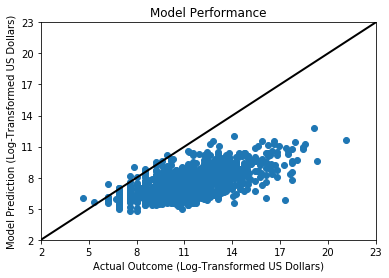

In [32]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [33]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.1212  0.1006  0.0305  0.2504  0.1402 -0.0102  0.1125 -0.1017  0.2065  0.0570
 0.0058 -0.0985  0.1154 -0.0722 -0.0995  0.0821  0.0519  0.0953 -0.1952  0.1503
-0.1023  0.0496 -0.0804  0.2186  0.0542 -0.0682 -0.0196 -0.0382 -0.0342 -0.1385
 0.1158  0.0966  0.1628  0.0171  0.2135  0.0422  0.0011  0.0490 -0.1573 -0.0484
 0.1574  0.0462  0.0179  0.0361  0.2622 -0.0183  0.1052  0.1802  0.0546  0.0896
-0.1144 -0.1652 -0.1220  0.2553  0.2611 -0.1327 -0.0039 -0.0694  0.2054  0.1048
 0.1471 -0.2403  0.0893  0.0122  0.1988 -0.0470 -0.0437 -0.0160  0.0135  0.2017
 0.2336 -0.0137 -0.0582 -0.0660  0.2234  0.1673  0.0008  0.0691 -0.0337  0.0858
-0.0264 -0.0728  0.0168  0.1122  0.2003  0.0427 -0.1427  0.0063 -0.0077  0.1985
-0.1414  0.1552  0.2058  0.0146  0.1407  0.0799  0.1959 -0.1174  0.1898  0.1587
 0.1596  0.0332  0.1901  0.0140  0.1315 -0.1674 -0.0024 -0.1626  0.1637  0.0290
-0.1570 -0.1898 -0.2052 -0.0581  0.0033  0.0559  0.0383 -0.1887  0.0366  0.0286
 

In [34]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.1581 -0.2049  0.2288  0.0295  0.2530  0.0791  0.1909  0.0401  0.0762  0.0084

Columns 10 to 14 
 0.0254  0.0178  0.1142  0.0019  0.1387
[torch.FloatTensor of size 1x15]

## Round 2: Two-Hidden-Layer Neural Network

In [35]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [36]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                            torch.nn.ReLU(),
                            torch.nn.Linear(15, 10),
                            torch.nn.ReLU(),
                            torch.nn.Linear(10, 1))

In [37]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 6e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

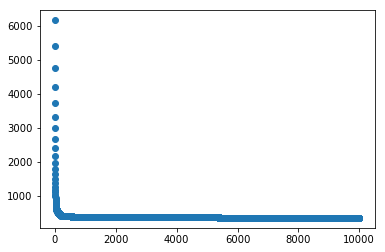

In [38]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [39]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4675)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

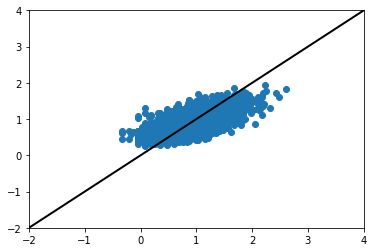

In [40]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 2.1: Validation Set Performance

In [41]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(15, 10),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(10, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight

In [42]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 759.5432
[torch.FloatTensor of size 1]

In [43]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1604)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

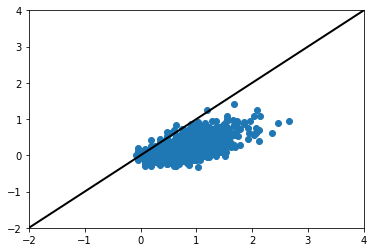

In [44]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 2.2: Test Set Performance

In [45]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(15, 10),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(10, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight
dim_corrected_model_2[(4)].weight = model[(4)].weight

In [46]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 1450.6819
[torch.FloatTensor of size 1]

In [47]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1596)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

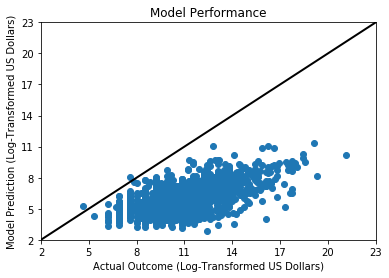

In [48]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [49]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.1217  0.2002  0.0152  0.1201  0.1951  0.0456  0.1811  0.0155  0.0202 -0.0466
-0.1216  0.2679  0.1006  0.0374  0.2370 -0.0820 -0.0428 -0.1677  0.1264 -0.1825
-0.0503  0.1393 -0.1431 -0.0688  0.0142  0.0861  0.0059  0.0380  0.2790  0.2701
-0.0136  0.1276 -0.1038 -0.0670  0.0226  0.0999 -0.2603 -0.1212  0.0898 -0.0059
-0.1340  0.0831 -0.1347  0.0284 -0.0222 -0.1213  0.1621  0.0702  0.0216  0.0216
-0.0413 -0.0849 -0.0429  0.0762  0.1281  0.0285 -0.0643  0.1484  0.2124  0.1022
 0.1750  0.0498  0.1786  0.2652  0.1929 -0.1129 -0.1399 -0.0735  0.0202  0.0915
-0.0122 -0.2433  0.0742  0.1804  0.3750 -0.0862 -0.0574  0.1321 -0.0594  0.0013
-0.1464  0.1137  0.2654 -0.0308  0.0495  0.1054 -0.0843  0.0746  0.0490  0.1092
 0.0280 -0.0642 -0.0269  0.1024 -0.0325  0.1904 -0.0242  0.1138  0.0828 -0.2166
-0.0565 -0.1697 -0.1126  0.0855  0.0742 -0.0650 -0.1638  0.0262 -0.1602 -0.0266
 0.1254  0.1353 -0.0550  0.1666 -0.0477  0.1058  0.1418 -0.0281  0.2012  0.0010
-

In [50]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.1181  0.1329  0.1583 -0.0153  0.0909  0.2261 -0.2678  0.1872 -0.2110  0.0670
 0.1412 -0.0381 -0.0799 -0.2249  0.2212 -0.1433 -0.0924  0.2381 -0.1160 -0.1573
 0.2449  0.1329  0.3165  0.1583 -0.0105  0.2853  0.0756  0.1658 -0.1142 -0.2307
-0.2098  0.2288 -0.0530  0.0147  0.1677  0.1005 -0.1271  0.0261 -0.2512 -0.0996
-0.0909 -0.1353 -0.0856 -0.1057  0.0882 -0.0800 -0.0762 -0.1509 -0.1124 -0.0806
-0.0777  0.1952  0.1388 -0.1771  0.1786 -0.0547  0.1116  0.0452 -0.2547  0.0714
 0.2213  0.2113  0.0045 -0.2606 -0.0064  0.2567  0.1244  0.1019 -0.1594 -0.1966
-0.2664  0.0429  0.3384  0.1208  0.0395  0.0792 -0.0278 -0.3017 -0.2453  0.0540
-0.1325  0.1658  0.2308 -0.0641 -0.0573  0.0181  0.3216  0.2580 -0.2282  0.1940
 0.1946 -0.1324 -0.1099 -0.0427  0.0082 -0.0375 -0.1752  0.0449  0.2283  0.2551

Columns 10 to 14 
-0.0568 -0.2180 -0.1229 -0.2165  0.2183
 0.2532 -0.0108  0.0981  0.0590  0.1714
-0.0109 -0.0911 -0.0150  0.0695 -0.2357
 0.2893  0.2036 -0.284

In [51]:
dim_corrected_model_2[(4)].weight

Parameter containing:
-0.1396  0.2910  0.4024 -0.3339  0.2619 -0.0507  0.3490 -0.4238  0.4264 -0.0420
[torch.FloatTensor of size 1x10]

## Round 3: Three-Hidden-Layers Neural Network

In [52]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [53]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                            torch.nn.ReLU(),
                            torch.nn.Linear(15, 10),
                            torch.nn.ReLU(),
                            torch.nn.Linear(10, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 1))

In [54]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 5e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

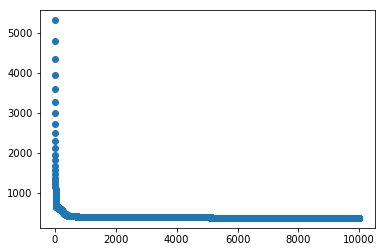

In [55]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [56]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4675)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

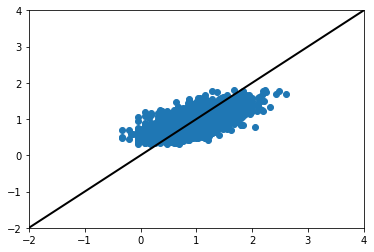

In [57]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 3.1: Validation Set Performance

In [58]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(15, 10),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(10, 7),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(7, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight
dim_corrected_model[(6)].weight = model[(6)].weight

In [59]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 1144.2200
[torch.FloatTensor of size 1]

In [60]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1604)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

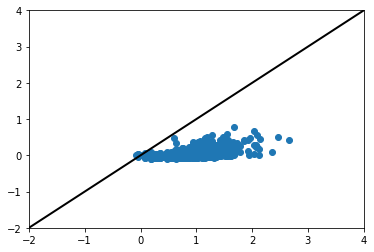

In [61]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 3.2: Test Set Performance

In [62]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(15, 10),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(10, 7),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(7, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight
dim_corrected_model_2[(4)].weight = model[(4)].weight
dim_corrected_model_2[(6)].weight = model[(6)].weight

In [63]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 605.0221
[torch.FloatTensor of size 1]

In [64]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1596)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

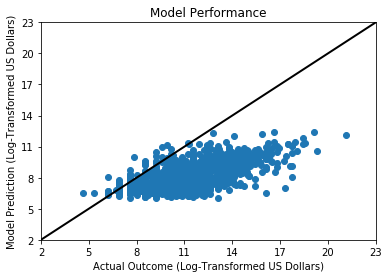

In [65]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [66]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.0001 -0.0255 -0.1270  0.1959  0.0895 -0.0754 -0.0284  0.1249  0.0984 -0.0218
-0.0911 -0.1001 -0.0278 -0.0601  0.1671  0.0407 -0.1504  0.0942  0.0110  0.1550
 0.0525 -0.0722  0.0361  0.0901 -0.1364 -0.1559 -0.1585 -0.1597 -0.0762 -0.1902
 0.0146 -0.0442 -0.1495 -0.0293 -0.1582 -0.1404 -0.0349  0.0150  0.0539  0.0281
 0.0571 -0.1777 -0.1439 -0.1108 -0.0548 -0.0365  0.1261 -0.0848 -0.0619 -0.1598
-0.2079 -0.0660 -0.1255 -0.1008 -0.1635  0.2192 -0.0427 -0.1212 -0.1564 -0.0560
 0.0324 -0.0222  0.1844 -0.0205 -0.2583 -0.2023  0.0324  0.0557 -0.0400  0.1470
-0.0420 -0.1752  0.1189 -0.0799  0.1071 -0.1082 -0.0619  0.1014  0.1545  0.1180
-0.0107 -0.1044 -0.1571 -0.1167  0.1611  0.1462 -0.1714 -0.1396 -0.2142  0.1371
-0.0840 -0.0584  0.1410  0.0800  0.2686  0.1153 -0.0480 -0.0814  0.2266  0.0459
 0.1279 -0.0828  0.1294  0.2276  0.2741 -0.1136  0.0228  0.0517  0.0923  0.1026
-0.0507  0.1058  0.2584 -0.1316 -0.1400  0.0567  0.0808  0.1705  0.0314 -0.0216
-

In [67]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.0625 -0.2628 -0.1464  0.2146  0.2272  0.2294  0.2316 -0.2090  0.1505  0.2778
-0.0990 -0.2076 -0.0613 -0.2446  0.0698 -0.1471 -0.2750 -0.0262  0.0874  0.0651
-0.0648 -0.0943 -0.2139 -0.1547  0.2084  0.1125 -0.1812 -0.0976  0.0200  0.1508
-0.1020 -0.1078 -0.1993  0.0352  0.1520 -0.1425 -0.1261 -0.2421 -0.1025 -0.1137
-0.1594  0.0216 -0.2190  0.2465  0.2207  0.1019 -0.1643  0.0846  0.0445 -0.1142
-0.0673  0.2569 -0.2141 -0.1321  0.0784  0.2319 -0.0454 -0.1809 -0.1520 -0.1643
 0.2035 -0.0362 -0.0528 -0.2331  0.1524 -0.1639 -0.1887  0.2004 -0.1640  0.0745
-0.0933 -0.1515 -0.1933 -0.0873  0.0627  0.0394  0.0957 -0.0284  0.1731 -0.1273
-0.2059  0.0491 -0.0215  0.2182  0.2420  0.2351  0.2648 -0.0490 -0.0953 -0.0760
 0.0526 -0.2077  0.1955 -0.0335  0.2134 -0.0526 -0.1718  0.0336  0.0088 -0.0858

Columns 10 to 14 
 0.2538  0.0338 -0.2362 -0.0210  0.1363
 0.0984  0.2388 -0.1036 -0.0404  0.0995
-0.3007  0.0230 -0.0070  0.1257  0.2628
-0.1223  0.1145  0.043

In [68]:
dim_corrected_model_2[(4)].weight

Parameter containing:
-0.2841  0.2593 -0.1676 -0.2027  0.2402 -0.1630  0.0559 -0.1929 -0.2982  0.2752
 0.2182 -0.3004  0.2809 -0.1853  0.2566 -0.1998 -0.1783  0.1842 -0.1881  0.1640
 0.3408 -0.1003 -0.1118  0.1590 -0.1162 -0.0578 -0.2303 -0.2971 -0.2319  0.2875
-0.3018 -0.1099 -0.2672  0.2028 -0.1004  0.1356 -0.0396 -0.1893 -0.2744 -0.2162
 0.0340  0.1034  0.2027  0.0264 -0.2227  0.1688 -0.0481  0.0984  0.3222 -0.3143
 0.2408 -0.1100  0.1117  0.0611  0.0519  0.0204 -0.0763  0.1785  0.0529 -0.2653
 0.0570  0.2600 -0.3414  0.1182  0.0692 -0.0433  0.6421  0.2509 -0.3410 -0.1542
[torch.FloatTensor of size 7x10]

In [69]:
dim_corrected_model_2[(6)].weight

Parameter containing:
-0.1971 -0.0120 -0.2228 -0.0597 -0.2052 -0.1701  0.7401
[torch.FloatTensor of size 1x7]

## Round 4: Four-Hidden-Layer Neural Network

In [70]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [71]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                            torch.nn.ReLU(),
                            torch.nn.Linear(15, 10),
                            torch.nn.ReLU(),
                            torch.nn.Linear(10, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 1))

In [72]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 5e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

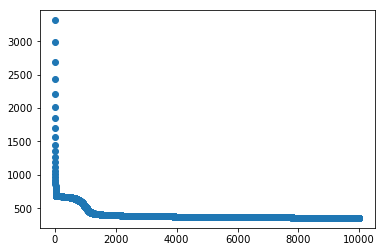

In [73]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [74]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4675)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

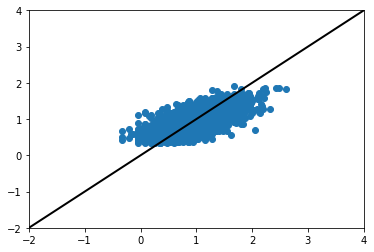

In [75]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 4.1: Validation Set Performance

In [76]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(15, 10),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(10, 7),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(7, 5),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(5, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight
dim_corrected_model[(6)].weight = model[(6)].weight
dim_corrected_model[(8)].weight = model[(8)].weight

In [77]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 1817.6917
[torch.FloatTensor of size 1]

In [78]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1604)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

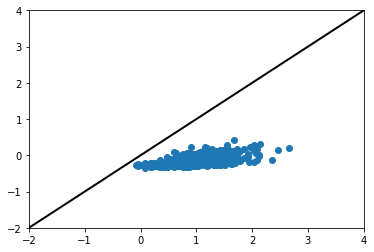

In [79]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 4.2: Test Set Performance

In [80]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(15, 10),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(10, 7),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(7, 5),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(5, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight
dim_corrected_model_2[(4)].weight = model[(4)].weight
dim_corrected_model_2[(6)].weight = model[(6)].weight
dim_corrected_model_2[(8)].weight = model[(8)].weight

In [81]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 461.3832
[torch.FloatTensor of size 1]

In [82]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1596)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

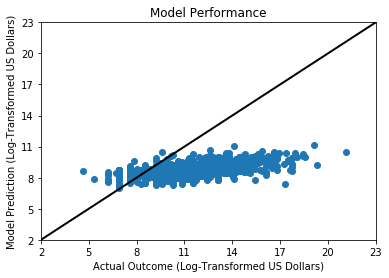

In [83]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [84]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.0915 -0.1604  0.2649  0.1588  0.1716 -0.1646 -0.1184  0.1280  0.0405  0.0985
-0.1135 -0.0509  0.1147  0.0045 -0.3188 -0.1702 -0.0417 -0.1150 -0.1535  0.2049
-0.0386  0.0794 -0.0662 -0.0513 -0.2592  0.0322 -0.1632 -0.0578 -0.2876  0.0734
-0.0909  0.1113 -0.0183  0.2237  0.3391  0.0766  0.1717  0.0598  0.0988  0.0016
 0.2407 -0.0323  0.1193 -0.0301  0.0188 -0.0154 -0.0490  0.2406  0.0332  0.2455
 0.0756  0.0255  0.0514  0.0868  0.0736  0.0067 -0.1397 -0.1804 -0.1908  0.0981
-0.1074  0.0836  0.0704 -0.1387  0.0021 -0.1026 -0.0344 -0.0297 -0.0041  0.1179
-0.1101  0.0215  0.0905 -0.0571 -0.0379  0.1660  0.1570  0.1263 -0.2182  0.1799
 0.1457  0.0457 -0.0815 -0.0464  0.0406 -0.0861  0.1622  0.0720  0.0080  0.1838
 0.0652  0.2009 -0.2110  0.0442 -0.0954  0.2373 -0.1061  0.1589 -0.2457  0.0271
 0.1304 -0.1481 -0.1270  0.1956  0.0964  0.0516 -0.1751  0.2507  0.1464 -0.0261
 0.0276 -0.0164  0.1383 -0.1692 -0.2119 -0.0091  0.0294  0.0785 -0.0088  0.0510
-

In [85]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.2546  0.0642  0.0689  0.1250  0.2381 -0.2379  0.1130  0.1172  0.1773 -0.1815
 0.2267  0.2089 -0.3413  0.2539 -0.1836  0.1648  0.1729 -0.1896  0.1519 -0.2471
-0.1507 -0.1520 -0.2328 -0.0617  0.3418  0.1669  0.0773 -0.1191 -0.1779  0.0148
-0.2343 -0.0791  0.1260  0.0869  0.2171  0.1156 -0.1012 -0.1259 -0.1183 -0.0643
 0.0597  0.3020 -0.0247  0.0139 -0.0911 -0.2659 -0.0612  0.1988 -0.1619 -0.1139
-0.2019 -0.2094 -0.0151 -0.2311  0.1251 -0.1221  0.1158 -0.0755  0.0053  0.1291
-0.2792 -0.1189  0.2976  0.1456 -0.0728  0.1610  0.2236 -0.0274  0.1844  0.0650
-0.2344 -0.1322 -0.1220 -0.0193  0.2469  0.0797 -0.0366 -0.2657 -0.0121 -0.1249
 0.0882 -0.0808 -0.0688  0.1254  0.0742  0.0146 -0.1214 -0.1254  0.0066  0.2548
-0.0817  0.0628  0.0165 -0.1471  0.0466  0.0481 -0.2155 -0.1682 -0.1553 -0.1691

Columns 10 to 14 
-0.0161 -0.1245 -0.0511  0.0040 -0.0657
-0.0631 -0.0727  0.0538  0.3715 -0.0569
-0.2200 -0.0129 -0.0814 -0.0790 -0.0080
-0.1830  0.1486  0.016

In [86]:
dim_corrected_model_2[(4)].weight

Parameter containing:
-0.2886 -0.1311 -0.1272 -0.2557 -0.2272  0.0053  0.1277  0.2429 -0.0273  0.2815
 0.2314 -0.1721  0.0459  0.2412  0.1022  0.0369  0.2605 -0.0942  0.0888  0.0925
 0.0102 -0.2919 -0.3677  0.1561  0.3868 -0.1208  0.3778 -0.0561 -0.2204  0.2825
-0.2342 -0.1760 -0.0738  0.1702 -0.2796  0.1751 -0.1978  0.0471 -0.2005  0.2207
 0.1102 -0.1740 -0.1675 -0.1374 -0.2874  0.1927  0.0646 -0.2170 -0.3065  0.0469
-0.1428  0.4077  0.1743 -0.2958 -0.0413  0.2358  0.1539  0.0196 -0.2416 -0.2591
 0.2308  0.5158  0.3145  0.1773 -0.3207 -0.2296  0.0865 -0.2235  0.1994  0.0278
[torch.FloatTensor of size 7x10]

In [87]:
dim_corrected_model_2[(6)].weight

Parameter containing:
 0.1008  0.2331  0.4697 -0.3484  0.2890 -0.2824 -0.0113
-0.2432  0.1356 -0.1282 -0.2876 -0.0212  0.2365 -0.3325
 0.1583 -0.0945 -0.6325 -0.0286  0.0427  0.1286  0.6238
 0.0840 -0.3045 -0.3053  0.0247  0.0041  0.2223  0.2088
 0.2127 -0.3221 -0.1268  0.2467 -0.2898  0.2416 -0.2325
[torch.FloatTensor of size 5x7]

In [88]:
dim_corrected_model_2[(8)].weight

Parameter containing:
-0.4696 -0.0621  1.0282 -0.0538 -0.3277
[torch.FloatTensor of size 1x5]

## Round 5: Five-Hidden-Layer Neural Network

In [89]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [90]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                            torch.nn.ReLU(),
                            torch.nn.Linear(15, 10),
                            torch.nn.ReLU(),
                            torch.nn.Linear(10, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 1))

In [91]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 5e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

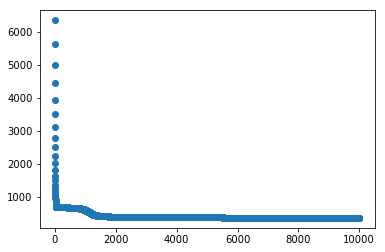

In [92]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [93]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4675)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

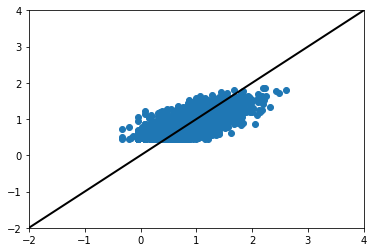

In [94]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 5.1: Validation Set Performance

In [95]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(15, 10),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(10, 7),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(7, 5),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(5, 3),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(3, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight
dim_corrected_model[(6)].weight = model[(6)].weight
dim_corrected_model[(8)].weight = model[(8)].weight
dim_corrected_model[(10)].weight = model[(10)].weight

In [96]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 688.1057
[torch.FloatTensor of size 1]

In [97]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1604)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

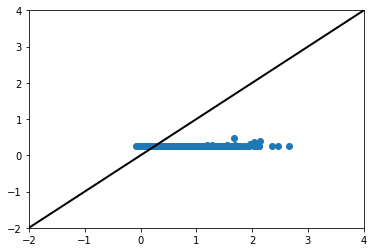

In [98]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 5.2: Test Set Performance

In [99]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(15, 10),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(10, 7),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(7, 5),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(5, 3),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(3, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight
dim_corrected_model_2[(4)].weight = model[(4)].weight
dim_corrected_model_2[(6)].weight = model[(6)].weight
dim_corrected_model_2[(8)].weight = model[(8)].weight
dim_corrected_model_2[(10)].weight = model[(10)].weight

In [100]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 758.6722
[torch.FloatTensor of size 1]

In [101]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1596)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

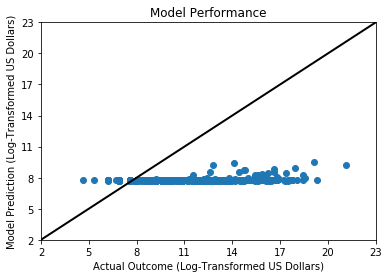

In [102]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [103]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.1703  0.0038 -0.0478  0.0807  0.1482 -0.1515 -0.0100  0.1387 -0.1435 -0.1383
-0.1623 -0.0311 -0.1339 -0.0392 -0.1854  0.2291 -0.0565  0.0316 -0.1467 -0.0069
 0.0281 -0.0770 -0.1971 -0.1805 -0.0264 -0.0058 -0.1353  0.0226 -0.0224  0.1196
 0.1615  0.1832 -0.1897  0.1809 -0.1040 -0.0280  0.1342 -0.2082  0.0304  0.1849
-0.1451 -0.0352 -0.1720 -0.1209 -0.0181  0.1167 -0.0031  0.1821  0.0771  0.1749
 0.1114  0.1881  0.2295  0.1201  0.2051 -0.1017 -0.1446  0.0975 -0.0556 -0.1510
-0.0702  0.0266  0.1345 -0.2041 -0.2242 -0.0471 -0.0506 -0.1134  0.0414  0.0225
-0.1773  0.0579  0.1124 -0.0458 -0.0743 -0.0994  0.0814  0.2181  0.0492 -0.1136
 0.0492 -0.0546 -0.0139  0.2685  0.3333 -0.0550 -0.0464  0.0677  0.1580  0.1134
-0.0960  0.2288 -0.1846  0.0247  0.0696  0.1208  0.1467 -0.0947  0.1024 -0.1611
 0.0618 -0.1221 -0.0879  0.1096 -0.3221 -0.0750  0.1585 -0.1844  0.0011 -0.1221
-0.0066 -0.1894 -0.0813 -0.0732 -0.0356 -0.2537  0.0664 -0.1113 -0.0732  0.0191
-

In [104]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.1117  0.2760 -0.0074  0.2404 -0.0051 -0.1953 -0.0914  0.1469 -0.0127 -0.0129
 0.0665  0.2401  0.1331  0.2205 -0.0438 -0.1125  0.2078  0.1403  0.2866 -0.1455
 0.1404 -0.0946 -0.1575  0.2093 -0.0003 -0.1658 -0.2230 -0.0388  0.3607  0.1137
 0.1983  0.0178 -0.0681 -0.0248  0.1628  0.2239 -0.2374 -0.0061  0.0793  0.2247
 0.0112 -0.1512  0.2198 -0.0715 -0.1271  0.1730 -0.2069  0.1933 -0.0568 -0.0884
 0.0793  0.2971  0.2679 -0.0419 -0.0953  0.0617  0.0738  0.2263 -0.0231  0.1063
-0.1437  0.1312  0.2189  0.1536  0.0922  0.0650 -0.1888  0.1550 -0.0351 -0.0433
-0.1471 -0.1171  0.2311 -0.2805  0.1486 -0.2447 -0.1329  0.1697  0.0062 -0.0480
 0.0303  0.0416 -0.1757 -0.1603  0.0107  0.3049 -0.0705 -0.0420  0.2185 -0.0000
-0.0642  0.1437  0.2265 -0.2378  0.1568  0.2087 -0.1972  0.0133 -0.0232 -0.2229

Columns 10 to 14 
 0.1267 -0.2054 -0.1006  0.0488  0.2315
-0.0865 -0.1465  0.1111  0.3260 -0.1883
-0.1676  0.1795  0.0383  0.2629  0.0923
-0.1467  0.0133 -0.043

In [105]:
dim_corrected_model_2[(4)].weight

Parameter containing:
 0.0194 -0.1005 -0.1304  0.0449  0.1731  0.3620  0.2250  0.0701 -0.0153 -0.1270
-0.0135 -0.1974  0.1429  0.0077 -0.2298  0.0444  0.0792 -0.2845 -0.2246 -0.2695
 0.3152  0.2342 -0.3048 -0.1329  0.0080  0.2723  0.0700  0.3224  0.0235 -0.1137
-0.0776 -0.2575 -0.0770 -0.2880 -0.2837 -0.0476  0.2837 -0.0927 -0.2887 -0.0813
 0.0549  0.0099 -0.0174 -0.2104  0.2369  0.1343  0.0432  0.0934  0.1859  0.3004
-0.2062  0.2906  0.3210  0.3804  0.1096 -0.0229 -0.2611 -0.1643  0.3451  0.0763
-0.2081 -0.0660  0.0510  0.2499  0.2920 -0.1870  0.0374  0.0508  0.2112  0.2116
[torch.FloatTensor of size 7x10]

In [106]:
dim_corrected_model_2[(6)].weight

Parameter containing:
 0.2891  0.1198 -0.2811 -0.3155 -0.3228  0.2146 -0.0733
-0.0929 -0.2201 -0.2888 -0.3661 -0.2457 -0.2788  0.0217
 0.0329  0.2599 -0.3540  0.3708 -0.0472 -0.1860  0.3706
-0.2565 -0.2446 -0.2492  0.2550  0.2380 -0.0725  0.2898
-0.5255 -0.2133 -0.4807 -0.0200 -0.3440  0.6578  0.2164
[torch.FloatTensor of size 5x7]

In [107]:
dim_corrected_model_2[(8)].weight

Parameter containing:
-0.0846  0.3765 -0.1125  0.0833  0.0147
 0.4592  0.3451 -0.0136 -0.0005  0.9385
 0.0841 -0.2200 -0.3828 -0.1203 -0.1746
[torch.FloatTensor of size 3x5]

In [108]:
dim_corrected_model_2[(10)].weight

Parameter containing:
-0.3150  0.9783 -0.2490
[torch.FloatTensor of size 1x3]

## Round 6: Six-Hidden-Layer Neural Network

In [109]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [110]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                            torch.nn.ReLU(),
                            torch.nn.Linear(15, 10),
                            torch.nn.ReLU(),
                            torch.nn.Linear(10, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(2, 1))

In [111]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 5e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

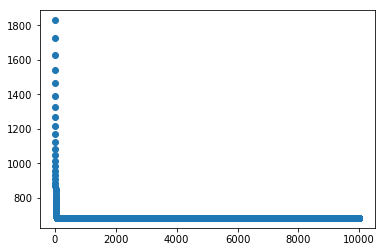

In [112]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [113]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4675)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

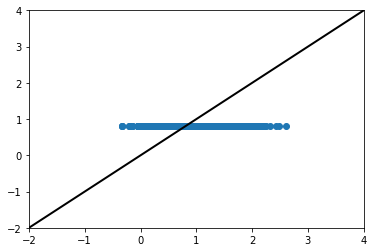

In [114]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 6.1: Validation Set Performance

In [115]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(15, 10),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(10, 7),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(7, 5),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(5, 3),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(3, 2),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(2, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight
dim_corrected_model[(6)].weight = model[(6)].weight
dim_corrected_model[(8)].weight = model[(8)].weight
dim_corrected_model[(10)].weight = model[(10)].weight
dim_corrected_model[(12)].weight = model[(12)].weight

In [116]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 2849.0059
[torch.FloatTensor of size 1]

In [117]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1604)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

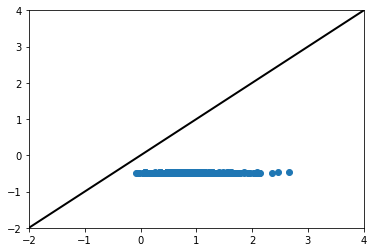

In [118]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 6.2: Test Set Performance

In [119]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(22, 15),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(15, 10),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(10, 7),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(7, 5),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(5, 3),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(3, 2),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(2, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight
dim_corrected_model_2[(4)].weight = model[(4)].weight
dim_corrected_model_2[(6)].weight = model[(6)].weight
dim_corrected_model_2[(8)].weight = model[(8)].weight
dim_corrected_model_2[(10)].weight = model[(10)].weight
dim_corrected_model_2[(12)].weight = model[(12)].weight

In [120]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 300.9489
[torch.FloatTensor of size 1]

In [121]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1596)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

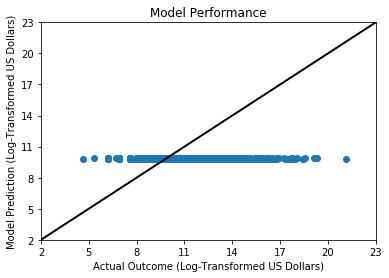

In [122]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [123]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.1713 -0.0114  0.1713 -0.0036  0.1858 -0.1683 -0.0842  0.0284  0.1333  0.1910
-0.0011 -0.0662 -0.0846 -0.2039  0.0959  0.1600 -0.1200  0.0584 -0.2035  0.0235
 0.1868  0.2046  0.1803 -0.0708  0.0591  0.1234  0.1787 -0.1311 -0.1002 -0.1736
 0.0381 -0.0174 -0.1188  0.0210  0.0351 -0.0967 -0.0167 -0.0124 -0.1004  0.0548
-0.0231  0.0527  0.1907 -0.0393  0.1149 -0.1935  0.0601 -0.1465  0.2048 -0.0075
 0.0477  0.1782 -0.2080  0.0149 -0.0237  0.1486 -0.0036  0.1253  0.1707  0.1530
-0.0116 -0.2069  0.1525  0.0406  0.0243  0.0542 -0.1160  0.1883 -0.2081  0.0138
 0.0210 -0.0034 -0.1769  0.1104  0.1448  0.0897 -0.1553  0.0183 -0.1884 -0.1530
-0.1406 -0.1614  0.0458 -0.0483  0.0727 -0.0605 -0.1928  0.0980  0.1535 -0.1162
 0.0300 -0.0542  0.0242  0.0852 -0.1460  0.1499 -0.0542 -0.2044  0.1524 -0.1896
-0.1507 -0.0546  0.0716 -0.0847 -0.0045  0.1024  0.1717 -0.1504  0.0348 -0.0921
 0.1083  0.0743 -0.0556  0.2018 -0.1919  0.2081 -0.1623  0.0532  0.0332  0.2109
 

In [124]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.1804 -0.2147  0.1973  0.1236 -0.1277  0.0747 -0.1578  0.1926 -0.2523  0.0668
-0.0467  0.1187 -0.1176 -0.2126 -0.0823  0.2038  0.2070 -0.1727  0.1748 -0.1176
 0.2421 -0.0163  0.2119 -0.0519 -0.1761  0.1175 -0.1328  0.0578  0.1833 -0.0812
-0.0357  0.1480 -0.2343  0.0471  0.0301 -0.1454  0.0761 -0.2401  0.0307 -0.2257
-0.0640 -0.1029 -0.1253  0.1552  0.2500  0.1719  0.0685 -0.2038  0.0316  0.1634
 0.2341  0.2277 -0.0080  0.1939  0.1838  0.1092  0.1487  0.1507  0.0005 -0.2305
 0.1343 -0.0608  0.0809 -0.1088 -0.1768 -0.2225  0.0283  0.1121 -0.0338 -0.1600
 0.0978 -0.0156 -0.1918  0.1585  0.0366  0.0229 -0.0669 -0.0155 -0.0998  0.0538
-0.1170 -0.0939 -0.1066  0.1042  0.1916 -0.0239 -0.0114 -0.1252 -0.2390 -0.2406
-0.1973 -0.0610 -0.1369  0.0808 -0.2488  0.1221 -0.2536 -0.1440  0.1655 -0.2034

Columns 10 to 14 
-0.0485 -0.1745 -0.1649 -0.2183  0.0776
 0.0246  0.2560 -0.1021 -0.0279  0.1498
 0.1200 -0.0411 -0.1056 -0.0179  0.2404
-0.2480  0.2271  0.136

In [125]:
dim_corrected_model_2[(4)].weight

Parameter containing:
-0.0889  0.0380  0.2807  0.2560  0.1108  0.2441  0.0399 -0.2572  0.3023  0.1655
-0.2357  0.0763  0.1021  0.3080 -0.0420  0.0312 -0.1024  0.1436  0.1395  0.2075
 0.1602  0.2793  0.0706  0.0491 -0.0989  0.0795 -0.1787 -0.0243 -0.1446  0.0422
-0.0078  0.0763 -0.1025  0.2587  0.0550  0.1795  0.0303  0.0531 -0.1652  0.0095
-0.0061 -0.1786 -0.1832 -0.0621  0.0599 -0.0362 -0.2965  0.2424  0.1211  0.0412
 0.0611  0.2250  0.1668 -0.1830  0.0359  0.1678  0.2468 -0.0827 -0.0534 -0.2458
-0.2233 -0.1333  0.1709 -0.1892 -0.1631 -0.2541  0.0312  0.1297 -0.2207  0.0387
[torch.FloatTensor of size 7x10]

In [126]:
dim_corrected_model_2[(6)].weight

Parameter containing:
 0.2412 -0.3687 -0.2278  0.1178  0.0516  0.2866  0.0355
-0.0163 -0.0366  0.2049  0.2380 -0.2607 -0.1321  0.1653
-0.3546  0.0103 -0.1821 -0.1328 -0.2194  0.1063  0.1899
 0.0974 -0.0299  0.3661  0.2757 -0.0964 -0.0660  0.0078
 0.1790  0.3274  0.3622  0.3329  0.2754 -0.0061  0.2455
[torch.FloatTensor of size 5x7]

In [127]:
dim_corrected_model_2[(8)].weight

Parameter containing:
-0.2618  0.2893  0.1199 -0.2923  0.4348
-0.1527  0.1731  0.3687  0.2910  0.1117
 0.2001 -0.1514 -0.4196  0.0309 -0.1246
[torch.FloatTensor of size 3x5]

In [128]:
dim_corrected_model_2[(10)].weight

Parameter containing:
-0.3889  0.4320 -0.2892
 0.5061  0.5631  0.2433
[torch.FloatTensor of size 2x3]

In [129]:
dim_corrected_model_2[(12)].weight

Parameter containing:
-0.3026  0.4910
[torch.FloatTensor of size 1x2]

## Round 7: Linear Regression

In [130]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [131]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(22, 1))

In [132]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 4e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

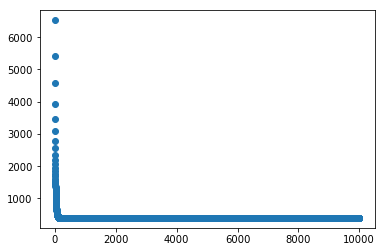

In [133]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [134]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4675)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

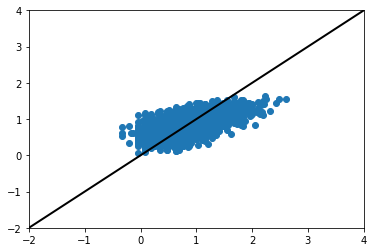

In [135]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 7.1: Validation Set Performance

In [136]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(22, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight

In [137]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 871.7584
[torch.FloatTensor of size 1]

In [138]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1604)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

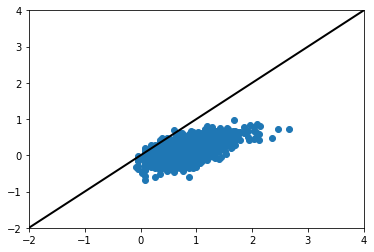

In [139]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 7.2: Test Set Performance

In [140]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(22, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight

In [141]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 653.6221
[torch.FloatTensor of size 1]

In [142]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1596)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

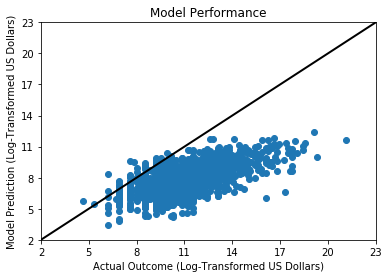

In [143]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [144]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.0304 -0.0025  0.0060  0.1194  0.1514 -0.0290  0.0040  0.0152  0.0504  0.0036

Columns 10 to 19 
 0.0377  0.0034  0.0102 -0.0124  0.0064 -0.0103 -0.0092  0.0168 -0.0053  0.0022

Columns 20 to 21 
 0.0042  0.0051
[torch.FloatTensor of size 1x22]